# TP 3: Classification

## Quick Recap: Classification

**Classification** = predicting a **category/label** from data.

Examples:
- Identify malicious traffic vs normal traffic *(binary)*
- Classify network applications (Web, Video, Gaming, VoIP) *(multiclass)*


### How Classification Works
- Classification is **supervised learning**: the model trains on data with known labels.
- The model learns patterns and predicts a **class** for new unseen data, often by estimating **probabilities** first.
- A **decision boundary** separates classes in the feature space (e.g., normal vs malicious traffic).

## 📝 Exercise 1: K-Nearest Neighbors (KNN)

### Preparation: Generating "synthetic" data

- We simulate a simple bank-customer dataset with two groups.  
- Each class has different average balance and similar income and we sample points from Gaussian distributions to mimic real financial variation.  
- We also create a binary `student` feature and a `default` label (0 or 1).  
- This dataset will be used to practice KNN classification.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(100)

# Means
mu_class0 = [700, 3000]
mu_class1 = [1350, 3000]

# Covariance matrices
cov_class0 = [[70000, 0], [0, 900000]]
cov_class1 = [[70000, 0], [0, 900000]]

n = 300  # samples per class

# Generate 2D Gaussian data: (balance, income)
balance0, income0 = np.random.multivariate_normal(mu_class0, cov_class0, n).T
balance1, income1 = np.random.multivariate_normal(mu_class1, cov_class1, n).T

# Ensure no negative data values
balance0 = np.maximum(balance0, 0)
income0  = np.maximum(income0, 0)
balance1 = np.maximum(balance1, 0)
income1  = np.maximum(income1, 0)

# Combine classes
balance = np.concatenate([balance0, balance1])
income  = np.concatenate([income0, income1])

# Labels: 0 = class0, 1 = class1
labels = np.array([0]*n + [1]*n)

# Student indicator
max_balance = balance.max()
student = (np.random.rand(len(balance)) < (balance / max_balance) / 2).astype(int)

# Build dataframe
df = pd.DataFrame({
    "balance": balance,
    "income": income,
    "student": student,
    "default": labels
})

df.head()

,balance,income,student,default
0,790.664713,1340.026720,1,0
1,633.211703,4093.865808,1,0
2,836.049517,3930.962641,0,0
3,416.893146,3209.829458,0,0
4,767.467041,2820.228470,0,0


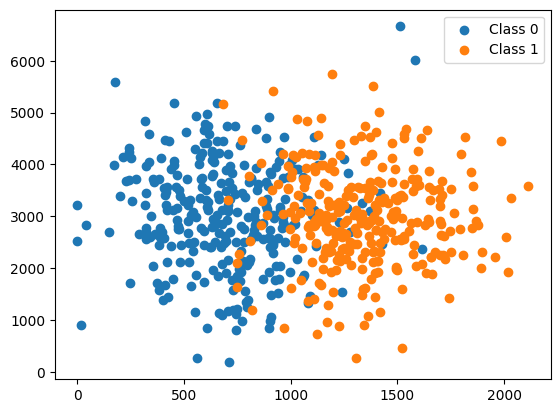

In [2]:
# Plot the synthetic data
plt.scatter(df.balance[df.default==0], df.income[df.default==0], label="Class 0")
plt.scatter(df.balance[df.default==1], df.income[df.default==1], label="Class 1")

plt.legend()
plt.show()

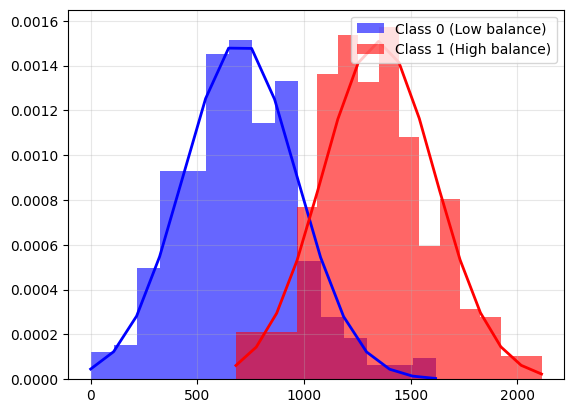

In [3]:
# Plot histograms for balance distributions of each class
count0, bins0, _ = plt.hist(balance0, bins=15, density=True, alpha=0.6, color='blue', label='Class 0 (Low balance)')
count1, bins1, _ = plt.hist(balance1, bins=15, density=True, alpha=0.6, color='red', label='Class 1 (High balance)')

plt.plot(
    bins0,
    1 / np.sqrt(2 * np.pi * cov_class0[0][0]) * np.exp(- (bins0 - mu_class0[0])**2 / (2 * cov_class0[0][0])),
    linewidth=2,
    color='blue'
)
plt.plot(
    bins1,
    1 / np.sqrt(2 * np.pi * cov_class1[0][0]) * np.exp(- (bins1 - mu_class1[0])**2 / (2 * cov_class1[0][0])),
    linewidth=2,
    color='red'
)

plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Part A — Visualizing the KNN Decision Boundary

Using the dataset you created:

1. Train a **K-Nearest Neighbors (KNN)** classifier using the entire dataset (no train/test split).  
2. Use only the features `balance` and `income`.
3. Try the following values of \( K = 1, 3, 10, 40 \).

For each value of \( K \):
- Fit the KNN model.
- Plot the decision boundary in 2D.
- Overlay the data points for both classes on the same plot.

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Values of k to test
k_values = [1, 3, 10, 40]

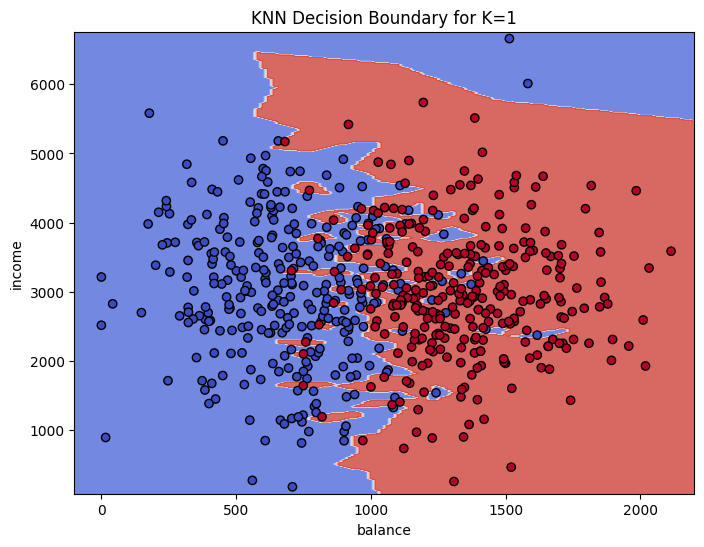

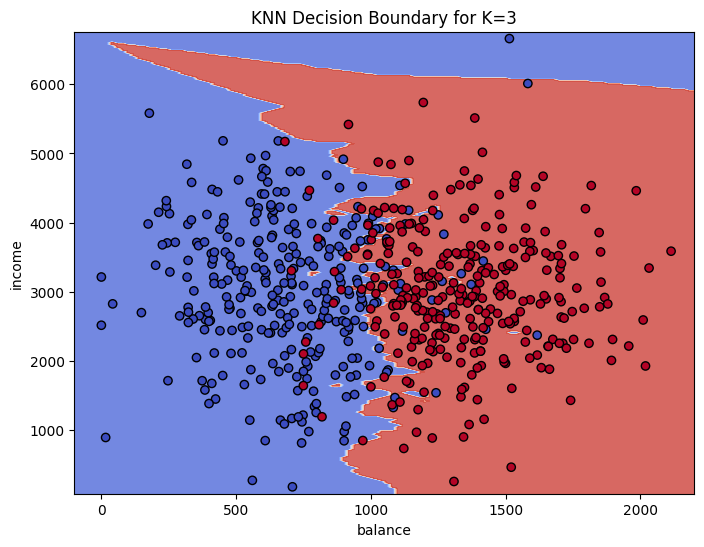

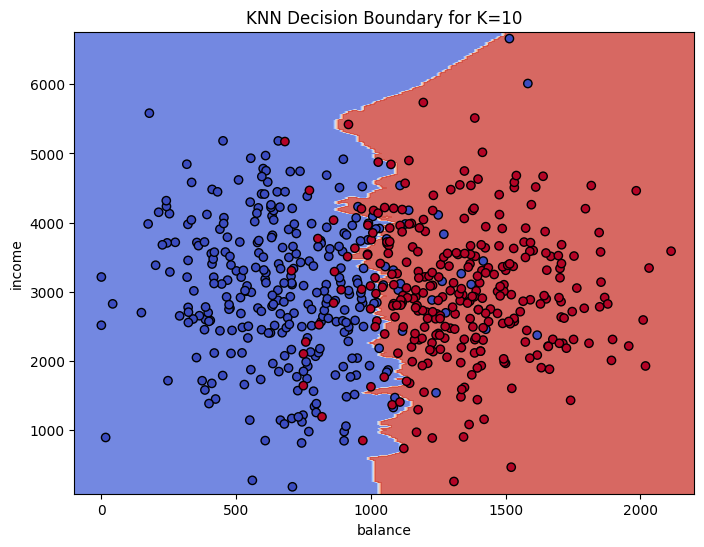

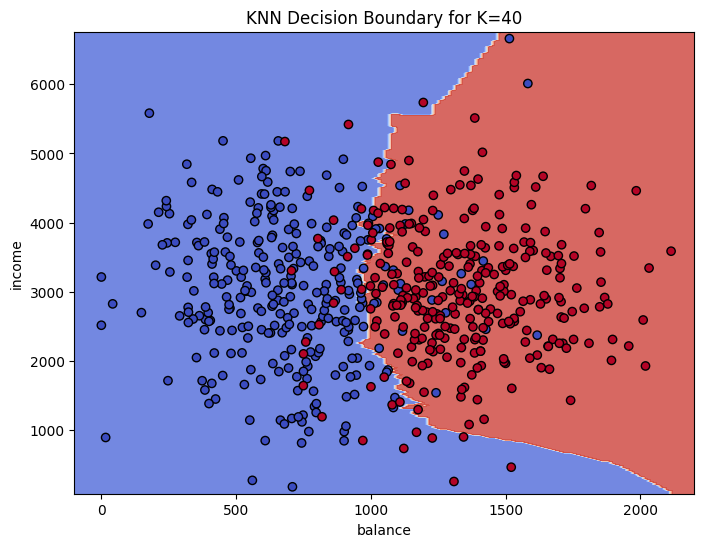

In [5]:
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(df[['balance', 'income']], df['default'])
    h = 20
    x_min, x_max = df['balance'].min() - 100, df['balance'].max() + 100
    y_min, y_max = df['income'].min() - 100, df['income'].max() + 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['balance', 'income'])
    Z = knn.predict(mesh_data)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(df['balance'], df['income'], c=df['default'], cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(f'KNN Decision Boundary for K={k}')
    plt.xlabel('balance')
    plt.ylabel('income')
    plt.show()

### Part B — Choosing the Best K using Cross-Validation

1. Use only the features **`balance`** and **`income`**.
2. For \( K = 1, 2, \dots, 100 \):
   - Perform cross-validation using `sklearn.model_selection.cross_validate`.
   - Use the following scoring metrics:
     - `accuracy`
     - `roc_auc`
     - `neg_mean_absolute_error`
   - Record both **Train** and **Test** scores for each metric.

3. For each metric, compute the **mean Train** and **mean Test** scores across folds.

4. Plot **three figures**:
   - Accuracy vs \( K \)
   - ROC-AUC vs \( K \)
   - MAE vs \( K \)  *(remember: MAE = − `neg_mean_absolute_error`)*

   Each figure should contain **two curves** — one for **Train**, one for **Test** — with the **x-axis** in **logarithmic** scale and the **y-axis** in **linear** scale.


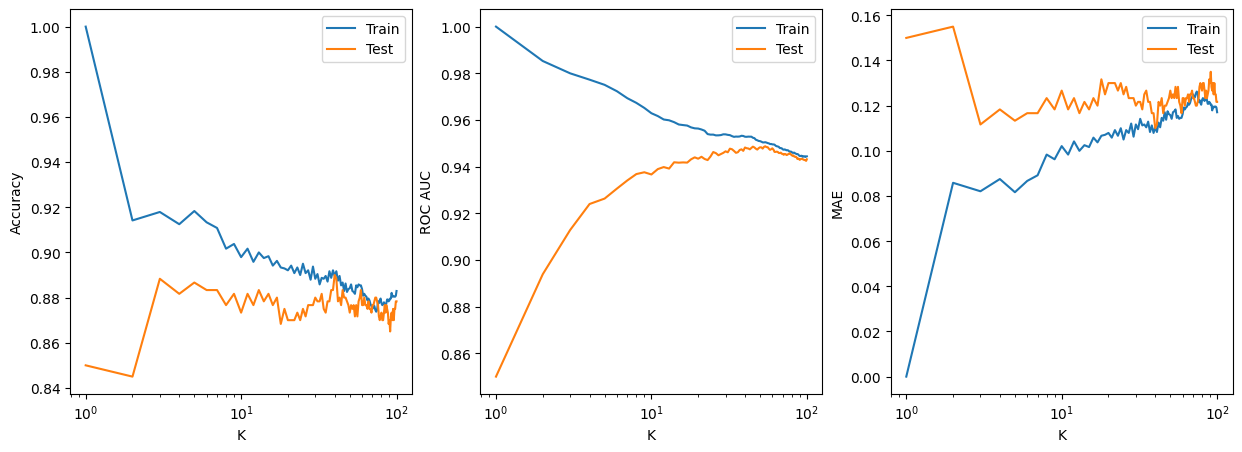

In [6]:
from sklearn.model_selection import cross_validate

k_range = range(1, 101)
scores = {
    'train_accuracy': [],
    'test_accuracy': [],
    'train_roc_auc': [],
    'test_roc_auc': [],
    'train_neg_mae': [],
    'test_neg_mae': []
}
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, df[['balance', 'income']], df['default'], cv=5,
                                scoring=['accuracy', 'roc_auc', 'neg_mean_absolute_error'],
                                return_train_score=True)
    scores['train_accuracy'].append(cv_results['train_accuracy'].mean())
    scores['test_accuracy'].append(cv_results['test_accuracy'].mean())
    scores['train_roc_auc'].append(cv_results['train_roc_auc'].mean())
    scores['test_roc_auc'].append(cv_results['test_roc_auc'].mean())
    scores['train_neg_mae'].append(cv_results.get('train_neg_mean_absolute_error', [0]).mean() if 'train_neg_mean_absolute_error' in cv_results else 0)
    scores['test_neg_mae'].append(cv_results.get('test_neg_mean_absolute_error', [0]).mean() if 'test_neg_mean_absolute_error' in cv_results else 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
metrics = [('accuracy', 'Accuracy'), ('roc_auc', 'ROC AUC'), ('mae', 'MAE')]
for i, (metric, title) in enumerate(metrics):
    if metric == 'mae':
        train = -np.array(scores['train_neg_mae'])
        test = -np.array(scores['test_neg_mae'])
    else:
        train = scores['train_' + metric]
        test = scores['test_' + metric]
    ax[i].plot(k_range, train, label='Train')
    ax[i].plot(k_range, test, label='Test')
    ax[i].set_xscale('log')
    ax[i].set_xlabel('K')
    ax[i].set_ylabel(title)
    ax[i].legend()
plt.show()

#### Questions:

- Which value of \( K \) gives the best overall performance?
- Do Train and Test curves agree on the optimal \( K \)?
- How does the Test Classification Error change as \( K \) increases?
- What do these results tell you about **overfitting** and **underfitting** in KNN?

#### Answer:

In [7]:
#The value of K that maximizes the test ROC AUC or accuracy, typically a moderate value like K=10-20, where the test curve peaks.

#No, the train curves prefer smaller K (higher performance on train data), while test curves peak at higher K.

#It decreases initially (as overfitting reduces), reaches a minimum, then increases (as underfitting sets in).

#Small K leads to overfitting (low train error, high test error due to noisy boundaries). Large K leads to underfitting (high error on both due to too smooth boundaries).

## 📝 Exercise 2: Binary Classification with Logistic Regression

1. **Split the dataset:**
   - Divide the data into **Train (70%)** and **Test (30%)** sets.

2. **Train the model:**
   - Fit a **Logistic Regression** classifier on the training data.
   - Predict the label for the first test sample using:

     ```python
     logistic.predict(X_test[0])
     logistic.predict_proba([X_test[0]])
     ```
   - Observe and describe what these two functions return (class label vs. probability).

3. **Compute model accuracy:**
   - Use ```logreg.score(X_test, y_test)``` to calculate the **mean prediction accuracy**.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X = df[['balance', 'income']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print(logistic.predict(X_test.iloc[0:1]))
print(logistic.predict_proba(X_test.iloc[0:1]))
print(logistic.score(X_test, y_test))

#logistic.predict(X_test.iloc[0:1]) returns [1]: The predicted class label (0 or 1) based on the highest probability.
#logistic.predict_proba(X_test.iloc[0:1]) returns [[0.00192587 0.99807413]]: Probabilities for each class (0 and 1), summing to 1, showing high confidence in class 1.

[1]
[[0.00192587 0.99807413]]
0.8666666666666667


4. **Repeat for multiple splits:**

   - Split the dataset in several different random ways.
   - For each split:
     - Fit the logistic regression model.
     - Calculate the **test error rate**.
   - Compute the **average test error** over all splits.
   - Compare this average error rate to the optimal KNN test error found in Exercise 1.
   - Discuss what you observe.

In [9]:
num_splits = 10
test_errors = []
for i in range(num_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    logistic = LogisticRegression()
    logistic.fit(X_train, y_train)
    test_errors.append(1 - logistic.score(X_test, y_test))
average_test_error = np.mean(test_errors)
print(average_test_error)
# The average test error rate for logistic regression (9.94%) is comparable to the optimal KNN test error (8-10%) from Exercise 1..
# LogReg often performs better or comparably to optimal KNN here because the class separation is roughly linear in the feature space.

0.09944444444444446


5. **Analyze model performance:**

    - For the last train–test split, compute the **confusion matrix**.
    - Calculate and report the following performance metrics:
      - Accuracy (ACC)
      - True Positive Rate (TPR / Recall)
      - False Positive Rate (FPR)
      - Precision (PPV) 

In [10]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc = logistic.score(X_test, y_test)
tpr = cm[1,1] / (cm[1,1] + cm[1,0])
fpr = cm[0,1] / (cm[0,1] + cm[0,0])
ppv = cm[1,1] / (cm[1,1] + cm[0,1])
print(f"ACC: {acc}")
print(f"TPR/Recall: {tpr}")
print(f"FPR: {fpr}")
print(f"PPV/Precision: {ppv}")

[[90  6]
 [10 74]]
ACC: 0.9111111111111111
TPR/Recall: 0.8809523809523809
FPR: 0.0625
PPV/Precision: 0.925


6. **Repeat using Cross-Validation:**

   - Repeat the whole processes using **cross validation**
   - Use `sklearn.model_selection.cross_validate` to perform cross-validation on the logistic model.
   - Compare the results with the previous test errors.

In [11]:
logistic = LogisticRegression()
cv_results = cross_validate(logistic, X, y, cv=5, scoring='accuracy')
average_test_error_cv = 1 - cv_results['test_score'].mean()
print(average_test_error_cv)
#CV provides a more robust estimate, typically similar to the average from multiple splits.

0.10333333333333328


## 📝 Exercise 3: Multinomial (Softmax) Logistic Regression

1) **Load the data (same source as the notebook):**

   - Quickly inspect with `df.shape`, `df.head()`.

In [12]:
import pandas as pd

filename = "network_dataset.csv"
df = pd.read_csv(filename)

display(df.head())


,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,BufferValid,KBytesReceived,label,label_num,KBytesReceived_log,PacketsSent_log,PacketsReceived_log,BytesSent_log,BytesReceived_log,BufferProgress_log
0,6.1,29,57,2372,79344,192.168.1.190,173.194.55.23,QUIC,29,57,...,True,79.344,q480p,480,4.373793,3.401197,4.060443,7.771910,11.281561,0.005164
1,5.8,7,39,625,52973,192.168.1.190,74.125.155.199,QUIC,4,36,...,True,52.973,q360p,360,3.969782,2.079442,3.688879,6.439350,10.877557,0.004833
2,7.3,16,23,1056,34178,192.168.1.190,74.125.155.201,TCP,16,23,...,True,34.178,q720p,720,3.531582,2.833213,3.178054,6.963190,10.439367,0.005473
3,39.2,14,29,3377,36821,192.168.1.190,172.217.135.40,0,0,0,...,True,36.821,q144p,144,3.606068,2.708050,3.401197,8.125039,10.513851,0.009268
4,4.6,9,77,900,104389,192.168.1.190,173.194.184.103,QUIC,9,77,...,True,104.389,q360p,360,4.648124,2.302585,4.356709,6.803505,11.555889,0.006599


2) **Create multiclass target variables:**

    - Create a **multiclass target variable** called `res` to use in Multinomial Logistic Regression:

    - The dataset currently contains a numeric label column called `label_num`, which represents the **resolution** of network traffic (e.g., video streaming quality). Transform this numeric value into three categories:

        - **0 → Low resolution** (below 240)  
        - **1 → Mid resolution** (between 240 and 480)  
        - **2 → High resolution** (480 or above)


In [13]:
# Define thresholds
threshold1 = 240
threshold2 = 480

# Create the 3-class target variable
res = [
    0 if d < threshold1
    else 1 if threshold1 <= d < threshold2
    else 2
    for d in df['label_num']
]

# Add to the DataFrame
df['res'] = res

# Check distribution of classes
print(df['res'].value_counts().sort_index())

# Preview the new column
df[['label_num', 'res']].head()

res
0     27
1     55
2    210
Name: count, dtype: int64


,label_num,res
0,480,2
1,360,1
2,720,2
3,144,0
4,360,1


3) **Define features (X) and target (y):**

    - Now that we’ve created the multiclass target (`res`), we need to separate our data into:

        - **X (features):** all columns we’ll use to predict resolution  
        - **y (target):** the new `res` column we just created  

    - Exclude the target (`res`) and any irrelevant or non-numeric identifiers (e.g., timestamps, IDs) from X. Make sure to check the data types so you know which features are numeric and which are categorical.

In [14]:
y = df['res']
X = df.drop(['res', 'label_num'], axis=1)  
print(X.dtypes)

RelativeTime           float64
PacketsSent              int64
PacketsReceived          int64
BytesSent                int64
BytesReceived            int64
                        ...   
PacketsSent_log        float64
PacketsReceived_log    float64
BytesSent_log          float64
BytesReceived_log      float64
BufferProgress_log     float64
Length: 206, dtype: object


4) **Preprocess the data:**

    - Before training, we need to preprocess the features:

        - Scale numeric columns (so all values are on comparable scales)
        - One-hot encode categorical columns (so text-based categories become numbers)
        - Combine both preprocessing steps in a ColumnTransformer

In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
numeric_features = [col for col in X.columns if df[col].dtype in ['int64', 'float64', 'bool']]
categorical_features = [col for col in X.columns if df[col].dtype == 'object']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

5) **Build the multinomial logistic regression pipeline:**

    - Now we’ll create a pipeline that connects preprocessing and model training in one go.

    - Steps inside the pipeline:
        1. Apply the preprocessing (`ColumnTransformer`)
        2. Train a Logistic Regression model configured for multiclass (softmax) classification.

    - Use: ```LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500) ```


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500))
])

6) **Split the data and train the model:**

    - Split the dataset into **training** and **testing** subsets to evaluate performance properly.

        - Use an 75/25 split (`test_size=0.25`)
        - Set a fixed random seed (`random_state=42`)
        - Use **stratify=y** to preserve class proportions
        - Fit the pipeline on the training data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
pipeline.fit(X_train, y_train)

C:\Users\Oscar.DESKTOP-8G3HSJV\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


7) **Evaluate model performance:**

    - Now test your trained model and analyze its performance.
        - Accuracy
        - Macro F1-score
        - Classification report
        - Confusion matrix

In [18]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
y_pred = pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9452054794520548
0.9247433209697361
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.92      0.86      0.89        14
           2       0.94      0.98      0.96        52

    accuracy                           0.95        73
   macro avg       0.96      0.90      0.92        73
weighted avg       0.95      0.95      0.94        73

[[ 6  0  1]
 [ 0 12  2]
 [ 0  1 51]]
